In [ ]:
'''-----feature engineering-----'''

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

In [2]:
filename = 'NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#performing the Non-Standart Missing Values checking
missing_values = ["n/a", "na", "--"]
initial = pd.read_csv(filename, na_values = missing_values)
df = initial.copy()

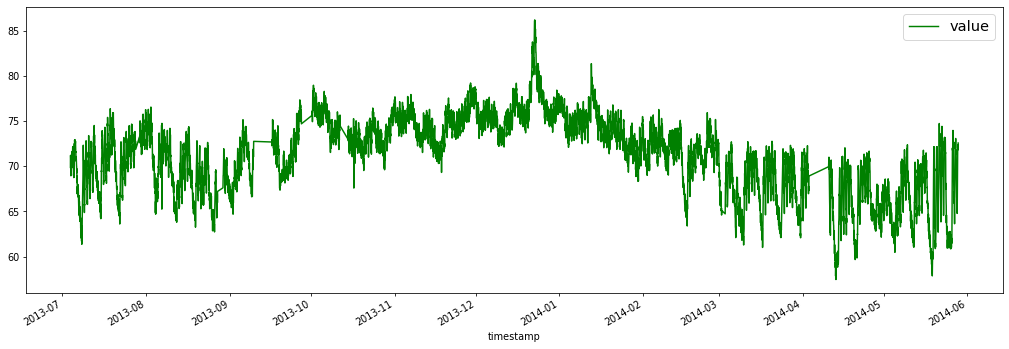

In [157]:
#plotting the data; 
initial['timestamp'] = pd.to_datetime(initial['timestamp'])
initial.plot(x='timestamp',x_compat=True,style='g', figsize=(18, 6))
plt.legend(fontsize=15)
plt.show()

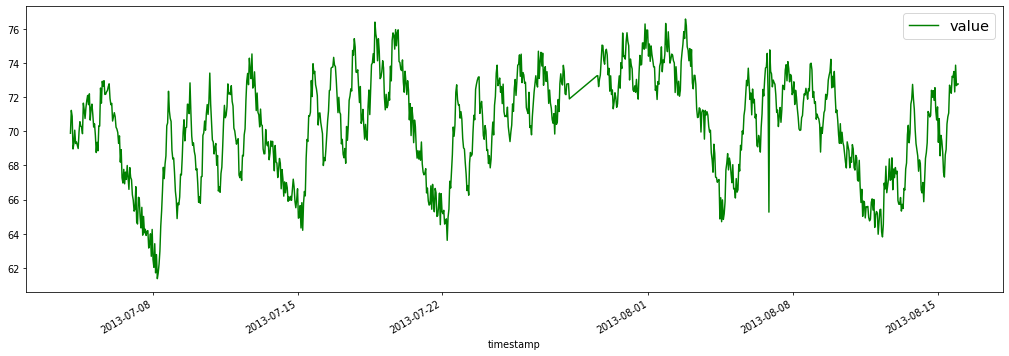

In [159]:
#lets see first 1000 points
initial.loc[:1000,:].plot(x='timestamp',x_compat=True,style='g', figsize=(18, 6))
plt.legend(fontsize=15)
plt.show()

In [4]:
initial

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [5]:
initial.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


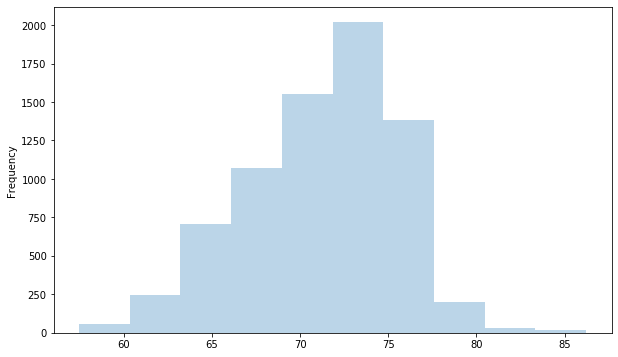

In [6]:
plt.figure()
initial['value'].plot.hist(alpha=0.3, figsize=(10,6))

In [7]:
# dealing with features; adding hours, weekday etc
def season_of_date(day):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if day in spring:
        return 1 #'spring'
    elif day in summer:
        return 2 #'summer'
    elif day in fall:
        return 3 #'fall'
    else:
        return 4 #'winter'

datepoints = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['hours'] = datepoints.dt.hour
df['weekday'] = datepoints.dt.weekday
# df['daylight'] = ...extract here the daylight info using time.daylight; problem: cannot access the whole series as its type is datetime64[ns]
# df['daylight'] = datepoints.dt.time.daylight ???
df['isweekend'] = df['weekday']>=5
df['dayofyear'] = datepoints.dt.dayofyear
df['year'] = datepoints.dt.year
df['season'] = datepoints.dt.dayofyear.map(season_of_date)
df['month'] = datepoints.dt.month
df

,timestamp,value,hours,weekday,isweekend,dayofyear,year,season,month
0,2013-07-04 00:00:00,69.880835,0,3,False,185,2013,2,7
1,2013-07-04 01:00:00,71.220227,1,3,False,185,2013,2,7
2,2013-07-04 02:00:00,70.877805,2,3,False,185,2013,2,7
3,2013-07-04 03:00:00,68.959400,3,3,False,185,2013,2,7
4,2013-07-04 04:00:00,69.283551,4,3,False,185,2013,2,7
...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11,2,False,148,2014,1,5
7263,2014-05-28 12:00:00,72.172956,12,2,False,148,2014,1,5
7264,2014-05-28 13:00:00,72.046565,13,2,False,148,2014,1,5
7265,2014-05-28 14:00:00,71.825226,14,2,False,148,2014,1,5


In [8]:
# now we're gonna compare the values through the days (for 2013)
df_2013 = df[df['year']==2013]
df_2013
df_by_hours_2013 = df_2013.pivot(index="hours", columns="dayofyear", values="value")

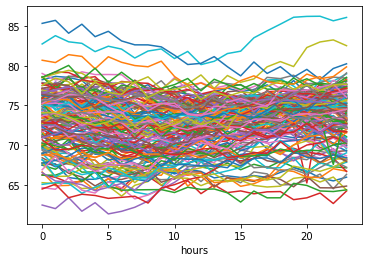

In [9]:
df_by_hours_2013.plot(legend=False)
# so there's very uninformative plot as it is too much info, even for a half of a year

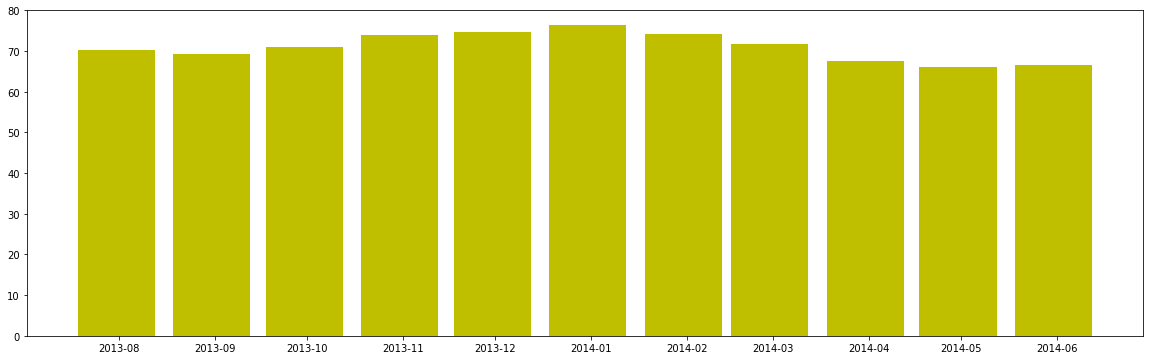

In [10]:
# bar plot by months
#reindexing 
df_ri_ts = pd.DataFrame(data=list(df['value']), index=datepoints, columns=['value'])
df_month = df_ri_ts.resample("M").mean()
#print(df_month)

fig, ax = plt.subplots(figsize=(20, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month.index, df_month.loc[:, "value"], width=25, align='center', color='y')
plt.show()

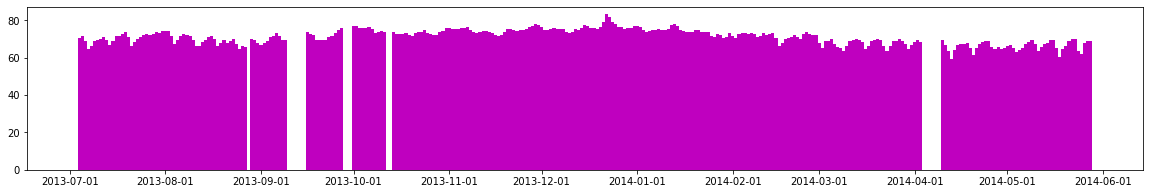

In [11]:
# bar plot by days
#reindexing 
df_day = df_ri_ts.resample("D").mean()

fig, ax = plt.subplots(figsize=(20, 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.bar(df_day.index, df_day.loc[:, "value"], width=1, align='center', color='m')
plt.show()

In [12]:
df_ri_ts.isnull().values.any()

False

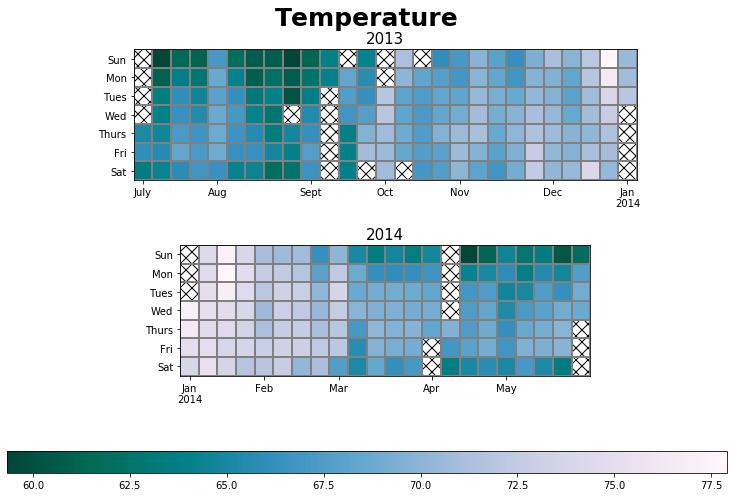

In [13]:
# heatmap code found and adapted from https://vietle.info/post/calendarheatmap-python/
df_day = df_ri_ts.resample("D").mean()
df_day.index = pd.to_datetime(df_day.index)

from matplotlib import colors

# Turn data frame to a dictionary for easy access
cal = {'2013': df_day[df_day.index.year == 2013], '2014': df_day[df_day.index.year == 2014]}

# Define Ticks
DAYS = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

#creating heatmaps
fig, ax = plt.subplots(2, 1, figsize = (20,6))
for i, val in enumerate(['2013', '2014']):
    #print(cal.get(val))
    start = cal.get(val).index.min()
    end = cal.get(val).index.max()
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun =  end + np.timedelta64(7 - end.dayofweek -1, 'D')

    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.full([7, num_weeks], np.nan)
    ticks = {}
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date <= end:
                heatmap[day, week] = cal.get(val).loc[date, 'value']
                #print(day, week, cal.get(val).loc[date, 'value'])
    mesh = ax[i].pcolormesh(x, y, heatmap, cmap = 'PuBuGn_r', edgecolors = 'grey')

    ax[i].invert_yaxis()

    # Set the ticks.
    ax[i].set_xticks(list(ticks.keys()))
    ax[i].set_xticklabels(list(ticks.values()))
    ax[i].set_yticks(np.arange(7))
    ax[i].set_yticklabels(DAYS)
    ax[i].set_ylim(6.5,-0.5)
    ax[i].set_aspect('equal')
    ax[i].set_title(val, fontsize = 15)

    # Hatch for out of bound values in a year
    ax[i].patch.set(hatch='xx', edgecolor='black')

# Add color bar at the bottom
cbar_ax = fig.add_axes([0.25, -0.10, 0.5, 0.05])
fig.colorbar(mesh, orientation="horizontal",  pad=0.2, cax = cbar_ax)
colorbar = ax[1].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
fig.suptitle('Temperature', fontweight = 'bold', fontsize = 25)
fig.subplots_adjust(hspace = 0.5)

#!!! deal with xx - cells

In [11]:
# this visualization also shows if there are missing days in dataset!

In [14]:
#split data into train and test dataset

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,shuffle=False)
df_train
#df_test

,timestamp,value,hours,weekday,isweekend,dayofyear,year,season,month
0,2013-07-04 00:00:00,69.880835,0,3,False,185,2013,2,7
1,2013-07-04 01:00:00,71.220227,1,3,False,185,2013,2,7
2,2013-07-04 02:00:00,70.877805,2,3,False,185,2013,2,7
3,2013-07-04 03:00:00,68.959400,3,3,False,185,2013,2,7
4,2013-07-04 04:00:00,69.283551,4,3,False,185,2013,2,7
...,...,...,...,...,...,...,...,...,...
5445,2014-03-05 21:00:00,71.354712,21,2,False,64,2014,4,3
5446,2014-03-05 22:00:00,70.391101,22,2,False,64,2014,4,3
5447,2014-03-05 23:00:00,69.438125,23,2,False,64,2014,4,3
5448,2014-03-06 00:00:00,70.258493,0,3,False,65,2014,4,3


In [ ]:
"""------data preprocessing-----"""

In [15]:
# find and filter out missing and incorrect values
#Missing Values
print('subdataframe with missing timestamp: \n',df[df['timestamp'].isnull()],'\n')
print('subdataframe with missing value: \n',df[df['value'].isnull()], '\n')
print('total missings by feature:\n',df.isnull().sum())
print('if there\'s any missing value:\n', df.isnull().values.any())

subdataframe with missing timestamp: 
 Empty DataFrame
Columns: [timestamp, value, hours, weekday, isweekend, dayofyear, year, season, month]
Index: [] 

subdataframe with missing value: 
 Empty DataFrame
Columns: [timestamp, value, hours, weekday, isweekend, dayofyear, year, season, month]
Index: [] 

total missings by feature:
 timestamp    0
value        0
hours        0
weekday      0
isweekend    0
dayofyear    0
year         0
season       0
month        0
dtype: int64
if there's any missing value:
 False


In [16]:
#Incorrect Values
#Assuming there's value in incorrect format unifying it
from numpy import nan
i = 0
for row in df['value']:
    try:
        float(row)
    except ValueError:
        df.loc[cnt, 'value'] = nan
    i += 1
print(df.isnull().values.any())

False


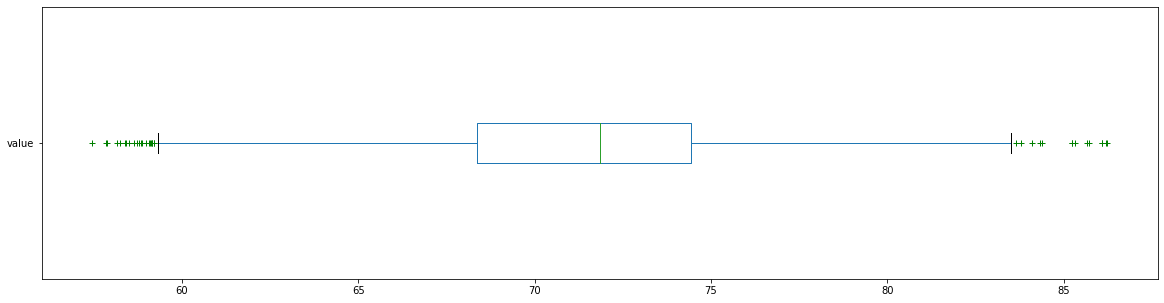

In [17]:
#discover outliers
#box plot
df['value'].plot.box(vert=False,sym="g+", figsize=(20, 5))

#so here we observe a set of low-temperatue values and high, but as they're not so distanced from median, I suppose it just caused by seasonal wavering

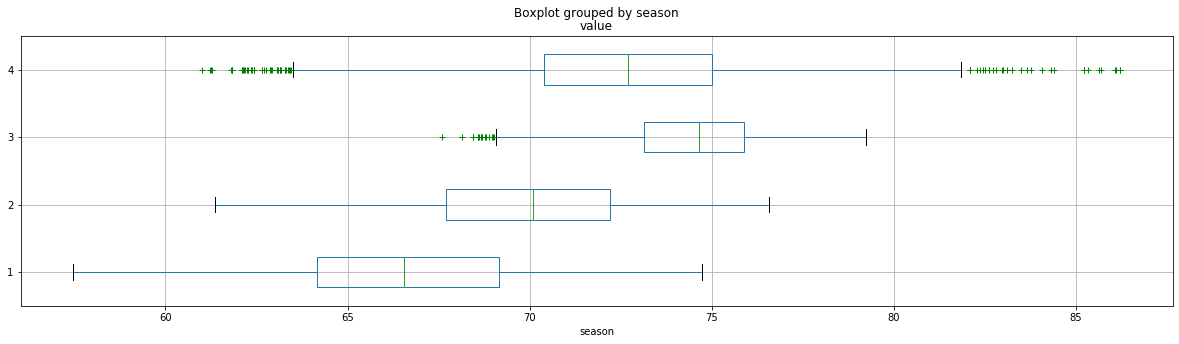

In [19]:
#lets discrete the values by season
seasons = ['spring', 'summer', 'fall', 'winter']

df.boxplot(by='season',column=['value'],vert=False,sym="g+", figsize=(20, 5), labels=seasons)

#however, it might be so unexpected that summer and spring are cooler in average

# during performing this block of code "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 
# (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
# If you meant to do this, you must specify 'dtype=object' when creating the ndarray
#   return array(a, dtype, copy=False, order=order)"" occured
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [20]:
#z-score
# The Z-score is the signed number of standard deviations 
# by which the value of an observation or data point is above 
# the mean value of what is being observed or measured.

from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['value']))
threshold = 3
print(np.where(z > 3)) #now we have an array with all the outliners indexes, for example:
print(df.loc[3718])

(array([3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728,
       3730, 6177, 6178, 6180, 6181, 7034, 7035, 7036], dtype=int64),)
timestamp    2013-12-22 17:00:00
value                    84.3909
hours                         17
weekday                        6
isweekend                   True
dayofyear                    356
year                        2013
season                         4
month                         12
Name: 3718, dtype: object


In [21]:
#IQR
# The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical 
# dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
# In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box 
# plot on the data.
# It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df[(df['value'] < (Q1 - 1.5 * IQR)) |(df['value'] > (Q3 + 1.5 * IQR))].count() #the dataframe that contains all the outliners

6.061547350000012


timestamp    35
value        35
hours        35
weekday      35
isweekend    35
dayofyear    35
year         35
season       35
month        35
dtype: int64

In [22]:
#so there are missing days in  our dataset. lets find them out
#creating test list
dp_lst = datepoints.to_list()

delta = dp_lst[-1] - dp_lst[0]
print(delta.components)
periods = delta.components[0]*24+delta.components[1]+1
# print(periods)
test_s = pd.date_range(dp_lst[0], periods=periods, freq="H")
test_lst = test_s.to_list()
print(len(test_lst))
#difference
missing_lst = list(set(test_lst) - set(dp_lst)) #the list of missing dates
print(len(missing_lst))

Components(days=328, hours=15, minutes=0, seconds=0, milliseconds=0, microseconds=0, nanoseconds=0)
7888
621


In [ ]:
'''------K-Means Clustering--------'''

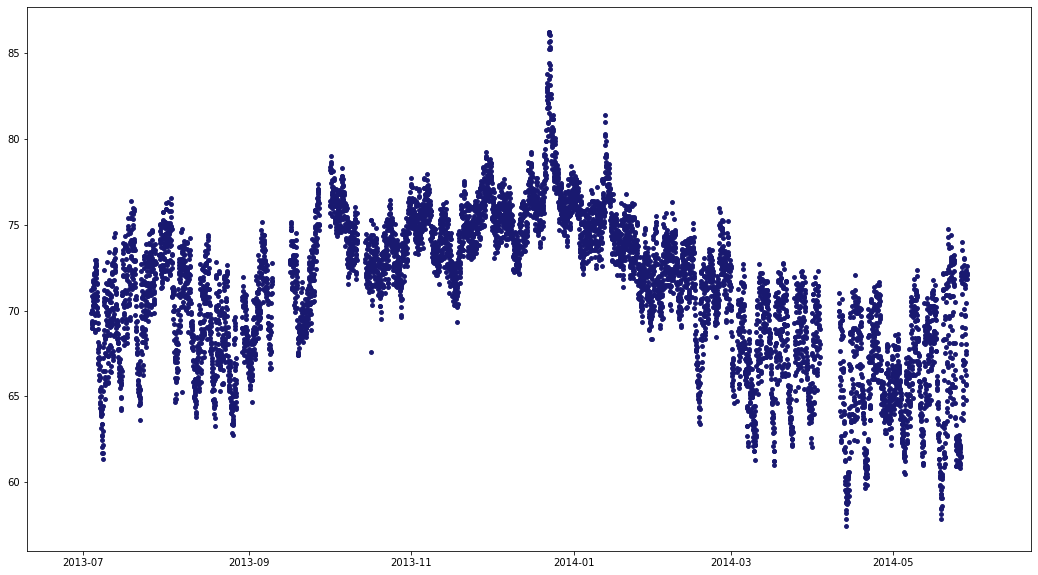

In [23]:
plt.figure(figsize=(18,10))
plt.scatter(datepoints, df.value, s=15,c='MidnightBlue')

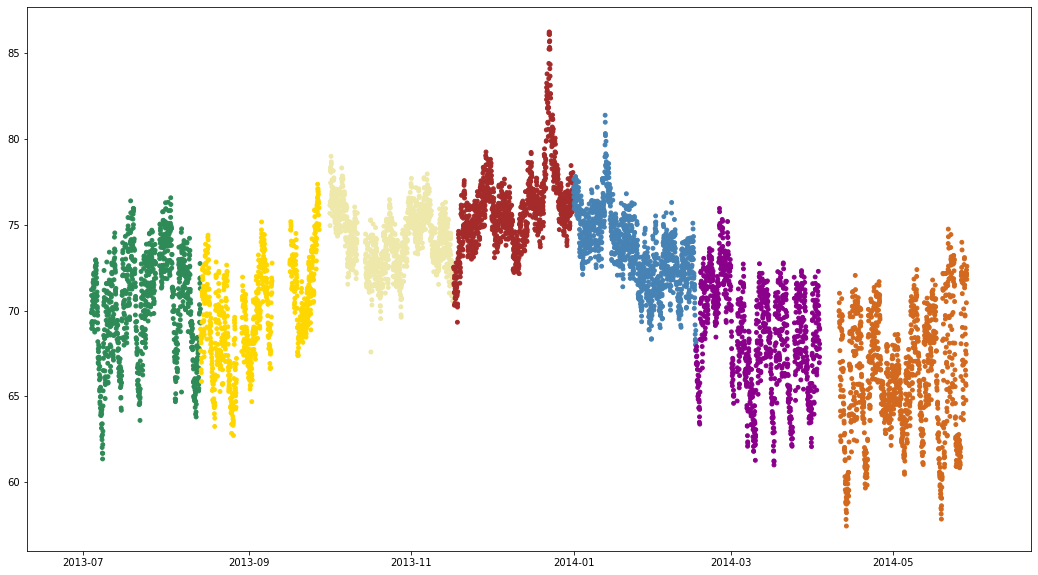

In [24]:
from sklearn.cluster import KMeans

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Fit the data into KMean model, default params are
# KMeans(copy_x=True, init='k-means++', max_iter=300,
#        n_clusters=3, n_init=10, n_jobs=1,
#        precompute_distances='auto',
#        random_state=None, tol=0.0001, verbose=0)
model = KMeans(n_clusters=7, max_iter=300)
model.fit(df.loc[:,'value':'month'])

# Plot the First iteration of the kmean.
colormap = np.array(['SeaGreen', 'SteelBlue', 'Brown','Chocolate', 'PaleGoldenRod','DarkMagenta','Gold'])
plt.figure(figsize=(18,10))
plt.scatter(datepoints, df.value, c=colormap[model.labels_], s=15)

In [27]:
# PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing

X = df.copy().loc[:,'value':'month']
X.isnull().sum()

#rescaling
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
new_df = pd.DataFrame(X_r, columns=['feature1', 'feature2'])

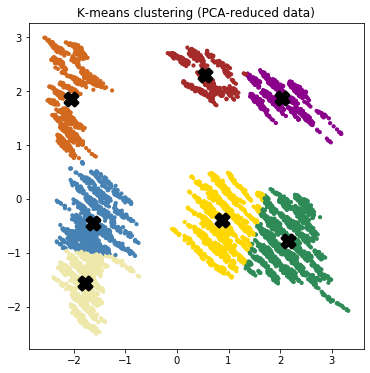

In [29]:
# Clusters visualisation 

# Cluste size.
K = 7
MAX_ITER = 100


# Kmean model
model = KMeans(n_clusters=K, max_iter=MAX_ITER)

model.fit(X_r)

colormap = np.array(['SeaGreen', 'SteelBlue', 'Brown','Chocolate', 'PaleGoldenRod','DarkMagenta','Gold'])
plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], c=colormap[model.labels_], s=10)

# Plot the centroids as a black X

centroids = model.cluster_centers_
new_df['class'] = model.labels_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=169, linewidths=3,
            color="k")
plt.title("K-means clustering (PCA-reduced data)")
plt.show()

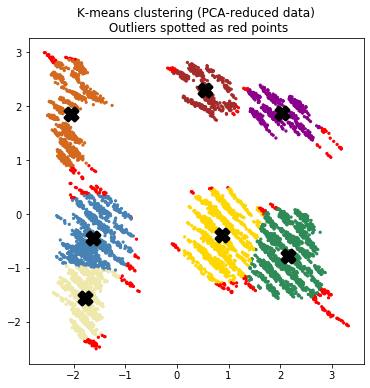

In [31]:
# finding outliers

colormap = np.array(['SeaGreen', 'SteelBlue', 'Brown','Chocolate', 'PaleGoldenRod','DarkMagenta','Gold', 'r'])
import math
OUT_PER = 0.05 # persentage of points that have greatest distance and are taken as anomalies


def distance(x, y):
    """
    Find distance between two points in a plain
    x: 2D point.
    y: 2D point.
    
    return euclidean distance between this points
    """
    d1 = x[0] - y[0];
    d2 = x[1] - y[1];
    distance = math.sqrt(d1*d1 + d2*d2)
    return distance


def get_outliers(df):
    """
    Reorganize the dataframe and assign to outliers the new class = K that will be plotted in red 
    All the outliers must be calculated within one class 
    The Anomaly rule:
    OUT_PER% of points that have greatest distance from centroid or their cluster are anomalies
    
    df: DataFrame with columns=['feature1', 'feature2', 'class'], class is integer from 0 to K-1
    return reorganized r_df 
    """
    r_df = df.copy()
    r_df['distance'] = [distance([r_df.loc[x,'feature1'],r_df.loc[x,'feature2']], centroids[r_df.loc[x,'class']]) for x in r_df.index]
    outliers = []
    for cls in r_df['class'].unique():
        df_cls = r_df[df['class'] == cls]
        low_bound = round(len(df_cls.index)*(1 - OUT_PER))
        df_srtd = df_cls.sort_values(by=['distance'])
        #print(df_srtd)
        outliers_cls = df_srtd[low_bound:]
        outliers+=list(outliers_cls.index.to_numpy())
    #print(len(outliers))
    r_df.loc[outliers,'class'] = K
        
    return r_df

# get_outliers(new_df)

# plotting
plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], c=colormap[get_outliers(new_df)['class']], s=5)

# Plot the centroids as a black X

centroids = model.cluster_centers_
new_df['class'] = model.labels_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=169, linewidths=3,
            color="k")
plt.title("K-means clustering (PCA-reduced data)\n Outliers spotted as red points")
plt.show()

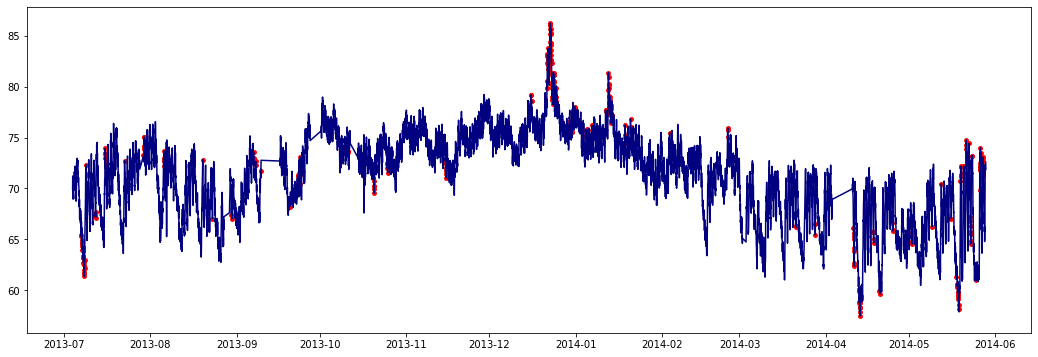

In [34]:
#k-means outliers
df_outliers_kmeans = initial.copy()
df_outliers_kmeans['class'] = get_outliers(new_df)['class']
ol = df_outliers_kmeans[df_outliers_kmeans['class']==K]

f, ax =  plt.subplots(figsize=(18,6))
ax.plot(df_outliers_kmeans['timestamp'].to_numpy(), df_outliers_kmeans['value'].to_numpy(),color='navy')
ax.scatter(ol['timestamp'], ol['value'], c='red', s=15)
plt.show()

In [ ]:
"""------Model Testing, Gaussian Tests-------"""

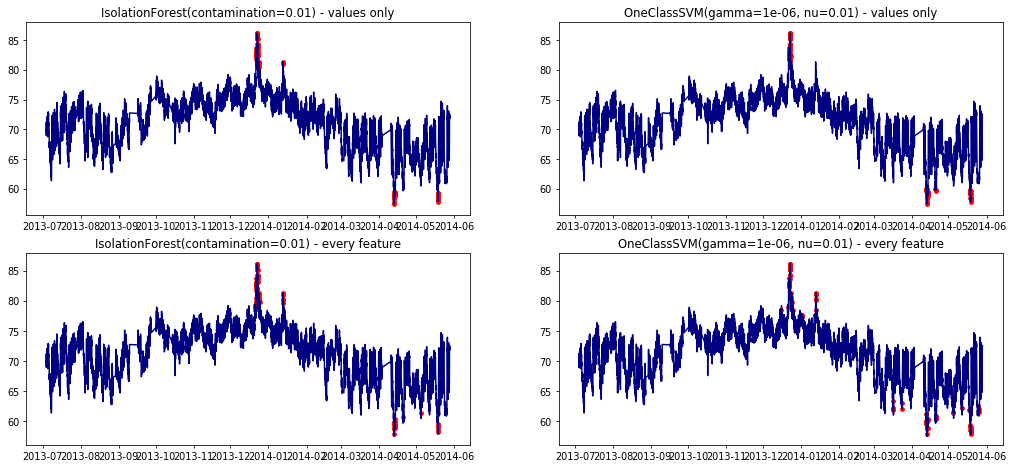

In [152]:
# Isolation Forest & One Class SVM
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

fig, ax = plt.subplots(2, 2, figsize = (18,8))

values = np.array(df['value'].copy()).reshape(-1, 1)
X = df.copy().loc[:,['value','hours','isweekend','season', 'month']]
for i, clf in enumerate([IsolationForest(contamination=0.01), OneClassSVM(nu=0.01, gamma=0.000001)]):
    # only values
    clf_v = clf.fit(values)
    valuesonly_df = pd.DataFrame(clf_v.predict(values), columns=['scores'])
    valuesonly_df['timestamp'] = pd.to_datetime(df['timestamp'])
    valuesonly_df['value'] = df['value']
    outliers_v = valuesonly_df[valuesonly_df['scores']<0]
#    print(outliers_v)
    
    
        # all the features
    clf_e = clf.fit(X)
    everyfeature_df = X.copy()
    everyfeature_df['scores'] = clf_e.predict(X)
    everyfeature_df['timestamp'] = pd.to_datetime(df['timestamp'])
    outliers_e = everyfeature_df[everyfeature_df['scores']<0]
#    print(outliers_e)
    
    #plotting
    ax[0,i].plot(df['timestamp'].to_numpy(), df['value'].to_numpy(),color='navy')
    ax[0,i].scatter(outliers_v['timestamp'], outliers_v['value'], c='red', s=15)
    ax[0,i].set_title("{} - values only".format(clf))
    
    ax[1,i].plot(df['timestamp'].to_numpy(), df['value'].to_numpy(),color='navy')
    ax[1,i].scatter(outliers_e['timestamp'], outliers_e['value'], c='red', s=15)
    ax[1,i].set_title("{} - every feature".format(clf))

plt.show()

In [31]:
# The svm.OneClassSVM is known to be sensitive to outliers and thus does not perform very well for outlier detection

In [32]:
# Gaussian dist

In [33]:
#visualization for each extracted feature

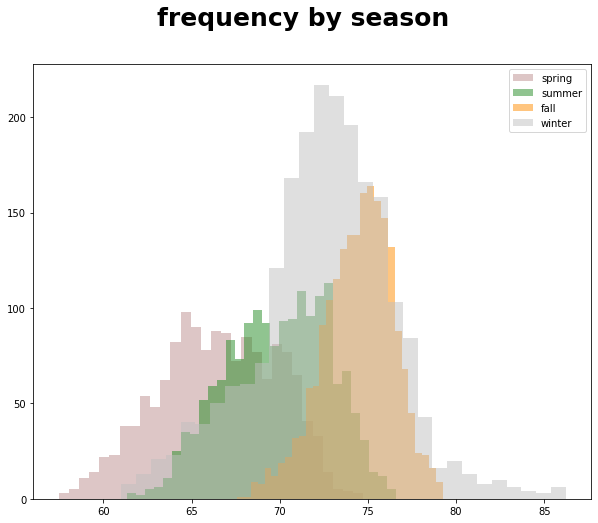

In [43]:
# seasons (4)
seasons = ['spring', 'summer', 'fall', 'winter']
colors = ['RosyBrown', 'ForestGreen', 'DarkOrange', 'Silver']
f = plt.figure(figsize=(10,8))
plt.rcParams.update({'figure.dpi':70})
for i in range(4):
    plt.hist(df.loc[df['season']==i+1, 'value'], color=colors[i], alpha=0.5, bins=30)
    #plt.set_title(seasons[i])
f.suptitle('frequency by season', fontweight = 'bold', fontsize = 25)
plt.legend(seasons)
plt.show()

In [44]:
# hours [00-23] -> morning[5-11), daytime[11-17), evening[17-23), night[23-5)

times = ['morning', 'daytime', 'evening', 'night']
df_byhours = df.copy().loc[:,['value','hours']]

def timeofday(hour):
    morning = range(5, 11)
    daytime = range(11, 17)
    evening = range(17, 23)
    # night = everything else

    if hour in morning:
        return 1 #'morning'
    elif hour in daytime:
        return 2 #'daytime'
    elif hour in evening:
        return 3 #'evening'
    else:
        return 4 #'night'
df_byhours['timeofday'] = df['hours'].map(timeofday)
df_byhours = df_byhours.loc[:,['timeofday','value']]

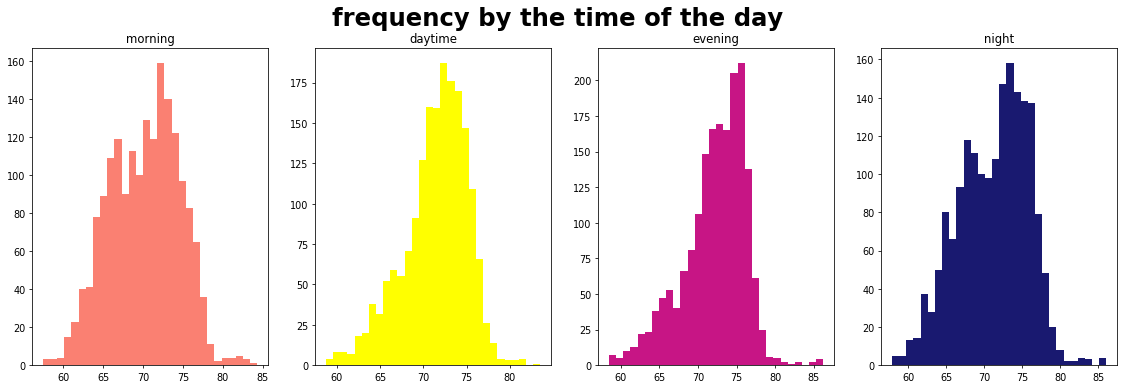

In [45]:
colors = ['Salmon', 'Yellow', 'MediumVioletRed', 'MidnightBlue']
f, ax = plt.subplots(1, 4, figsize=(20,6))
for i, ax_i in enumerate(ax):
    to_plot=df_byhours[df_byhours['timeofday']==i+1]
    ax_i.hist(to_plot['value'], color=colors[i], bins=30)
    ax_i.set_title(times[i])
f.suptitle('frequency by the time of the day', fontweight = 'bold', fontsize = 25)    
plt.show()

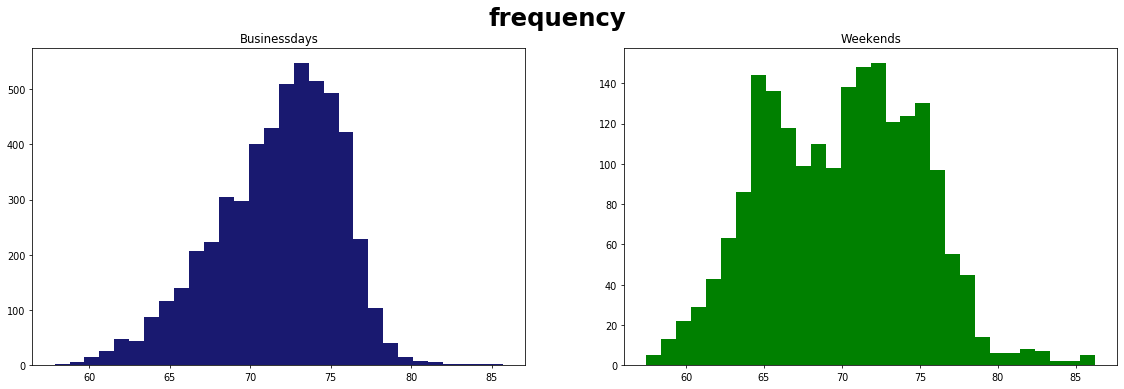

In [46]:
# weekend
colors = ['MidnightBlue', 'Green']
titles =['Businessdays', 'Weekends']
f, ax = plt.subplots(1, 2, figsize=(20,6))
for i, ax_i in enumerate(ax):
    ax_i.hist(df.loc[df['isweekend']==i]['value'], color=colors[i], bins=30)
    ax_i.set_title(titles[i])
f.suptitle('frequency', fontweight = 'bold', fontsize = 25)    
plt.show()
# unify the y scale!!!

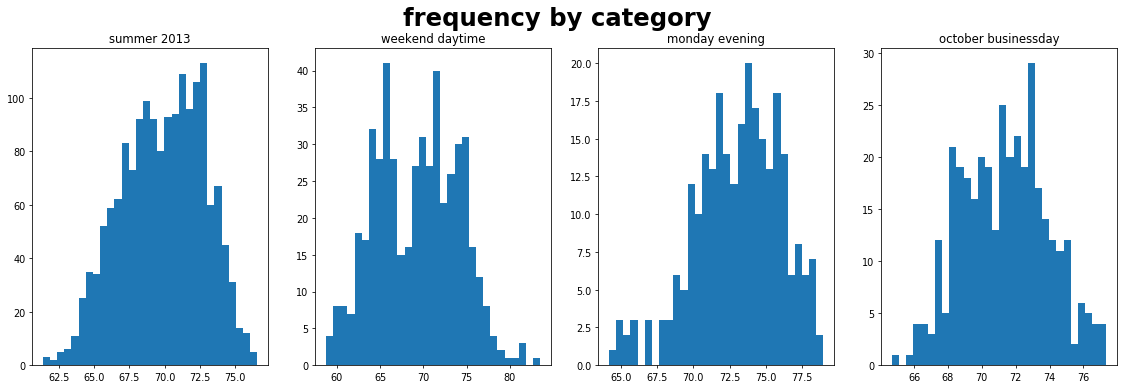

In [47]:
# having hours (weekday)=isweekend (dayofyear -unique) year season (month-unique) features we define categories:
# season-year (i.e. summer 2013)
# isweekend-hour (i.e. weekend daytime)
# day-hour (i.e. monday evening)
# month-isweekend (i.e. october businessday)
# added new feature - time of day

df['timeofday'] = df_byhours['timeofday']

f, ax = plt.subplots(1,4, figsize=(20,6))
categories = [{'season':2, 'year':2013}, {'isweekend':1, 'timeofday':2}, {'weekday':1, 'timeofday':3}, {'month':9, 'isweekend':0}]
titles = ['summer 2013', 'weekend daytime', 'monday evening','october businessday']

cats_v = []
for i, cat in enumerate(categories):
    f1 = [*cat][0]
    f2 = [*cat][1]
    
    tobeplotted = df[(df[f1]==cat[f1])&(df[f2]==cat[f2])]
    ax[i].hist(tobeplotted['value'], bins=30)
    ax[i].set_title(titles[i]) #?? add decryption dicts??
    cats_v.append(tobeplotted)
    
f.suptitle('frequency by category', fontweight = 'bold', fontsize = 25)    
plt.show()

In [39]:
#cats_v #list of dataframes by categories

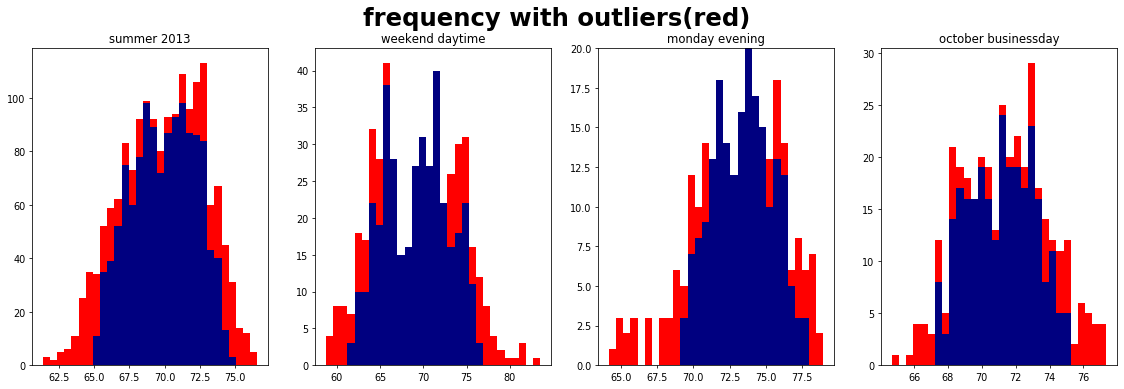

In [48]:
from sklearn.covariance import EllipticEnvelope

f, ax = plt.subplots(1, 4, figsize=(20,6))
for i, ax_i in enumerate(ax):
#    print(cats_v[i])
#    ax_i.scatter(cats_v[i].timestamp.to_numpy(), cats_v[i]['value'].to_numpy(), s=8)
    
    category_df = cats_v[i].copy()
    cov = EllipticEnvelope(random_state=0, support_fraction=1., contamination=0.25).fit_predict(category_df.loc[:,['value','hours']])
    category_df['cls'] = cov
#    outls = cats_v[i][cats_v[i]['cls']<0]
    a = category_df.loc[category_df['cls'] == 1, 'value']
    b = category_df.loc[category_df['cls'] == -1, 'value']
    
#    ax_i.scatter(outls['timestamp'].to_numpy(), outls['value'].to_numpy(), c='r', s=10)
#    ax[i].set_ylabel(titles[i])
    # at this point I stacked with 
#     VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
#   return array(a, dtype, copy=False, order=order)
    l = np.array([a,b], dtype=object)
    ax_i.hist(l, bins=30, stacked=True, color=['navy', 'red'])
    ax_i.set_title(titles[i])
f.suptitle('frequency with outliers(red)', fontweight = 'bold', fontsize = 25)    
plt.show()

In [ ]:
"""-------RNN--------"""

In [ ]:
# RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. 
# We consider an anomaly when the next data points are distant from RNN prediction. 
# Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
# Here we learn from 50 previous values, and we predict just the 1 next value.

In [49]:
#preprocessing step: prepare data for training and testing
data_n = df.loc[:,['value', 'hours', 'weekday','isweekend']]
data_n['timeofday'] = df_byhours['timeofday']
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)
#print(data_n)

# important parameters
prediction_time = 1 
unroll_length = 50

#train&test data
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(data_n, shuffle=False)

y_train = x_train.loc[:,0].to_numpy()
y_test = x_test.loc[:,0].to_numpy()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
print("x_train", x_train.shape)
print("x_test", x_test.shape)

x_train (5450, 5)
x_test (1817, 5)


In [50]:
#unroll: create a sequence of 50 previous data points for each data point
def unroll(data,sequence_length=24):
    """
    data: data sequence 
    sequence_length: default 24
    
    return a sequence where each data point is replaced by sequence of its previous data points
    """
    result = []
    for index in range(sequence_length, len(data)):
        result.append(data[index - sequence_length:index])
#        print(data[index - sequence_length:index-1].shape)
#    print(result)
    return np.asarray(result)

In [51]:
# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [52]:
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5400, 50, 5)
y_train (5400,)
x_test (1767, 50, 5)
y_test (1767,)


In [53]:
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers import Dense, Activation, Dropout, Conv1D, Input, Conv1DTranspose
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [54]:
# Build the model
model = Sequential()

model.add(LSTM(units=50,input_dim=x_train.shape[-1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.02053356170654297


In [55]:
# Train the model

model.fit(x_train,y_train,batch_size=3028,epochs=30,validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 19s 6s/step - loss: 0.9001 - val_loss: 0.2439
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 0.2954 - val_loss: 0.1400
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 0.1984 - val_loss: 0.1307
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 0.1584 - val_loss: 0.1073
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 0.0990 - val_loss: 0.0968
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 0.0909 - val_loss: 0.0960
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 0.0916 - val_loss: 0.0922
Epoch 8/30
2/2 [==============================] - 4s 2s/step - loss: 0.0897 - val_loss: 0.0948
Epoch 9/30
2/2 [==============================] - 4s 2s/step - loss: 0.0981 - val_loss: 0.0882
Epoch 10/30
2/2 [==============================] - 4s 2s/step - loss: 0.0948 - val_loss: 0.0838
Epoch 11/30
2/2 [==============================]

In [56]:
# create the list of differences between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

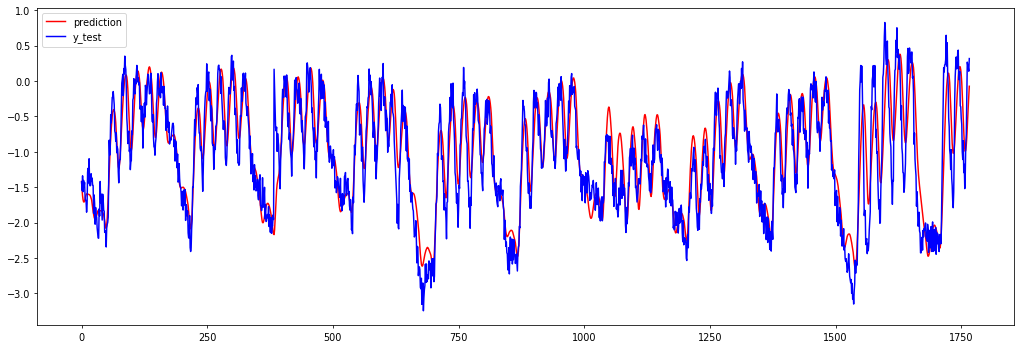

In [166]:
# plot the prediction and the real data (for the test data)
fig, axs = plt.subplots(figsize=(18,6))
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='b', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [58]:
# select the most distant predictied-real data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(0.01*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)

# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-len(x_test)))

# # add the data to the main
df['anomalyRNN'] = complement.append(test, ignore_index='True')
print('numbers of 1s is the amount of anomalies\n',df['anomalyRNN'].value_counts())

numbers of 1s is the amount of anomalies
 0    7250
1      17
Name: anomalyRNN, dtype: int64


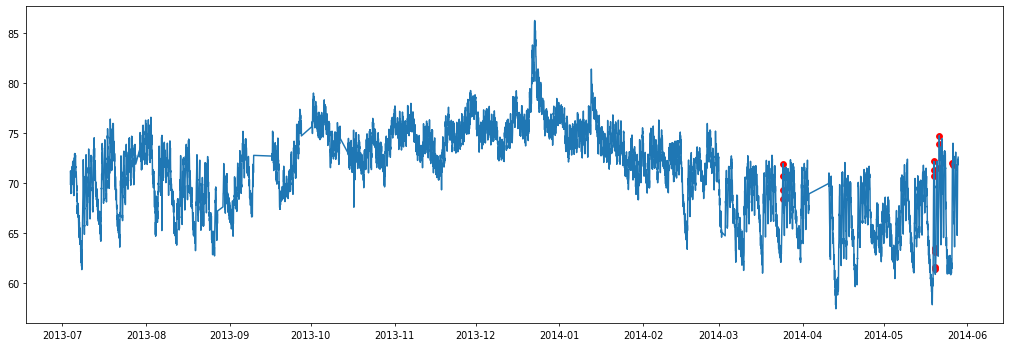

In [193]:
# visualisation of anomaly throughout time (no 1)

fig, ax = plt.subplots(figsize=(18, 6))

anomaly = df.loc[df['anomalyRNN'] == 1, ['timestamp','value']] 

ax.plot(df['timestamp'].to_numpy(), df['value'].to_numpy())
ax.scatter(anomaly['timestamp'].to_numpy(),anomaly['value'].to_numpy(), color='red')

plt.show()
# during performing this block of code next warning occured:
# FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed 
# in a future version.  Convert to a numpy array before indexing instead.
#   x[:, None]
# so there are .to_numpy() functions

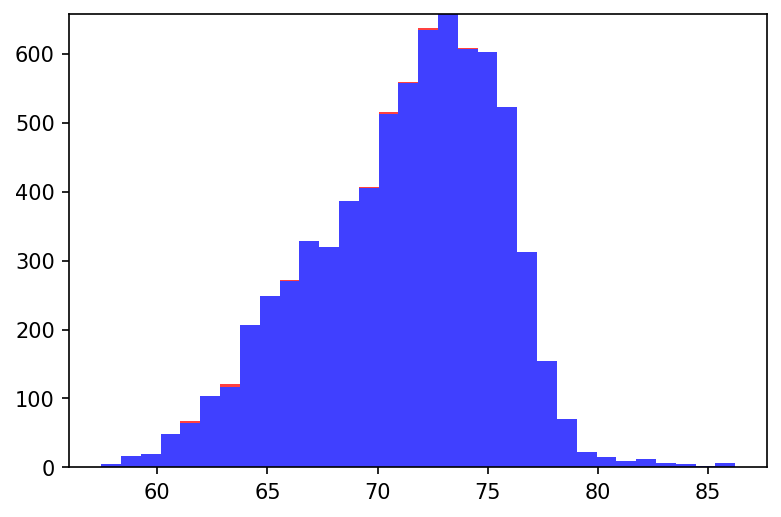

In [225]:
# visualisation of anomaly with temperature  (no 2)
no_a = df.loc[df['anomalyRNN'] == 0, 'value']
yes_a = df.loc[df['anomalyRNN'] == 1, 'value']

fig, axs = plt.subplots(dpi=150)
axs.hist([no_a,yes_a], bins=32, stacked=True, color=['blue','red'], alpha=0.75)
#fig.dpi(50)
plt.show()

In [ ]:
"""-------Anomaly Detection using Autoencoders-------"""

In [147]:
# prepare data for training and testing
data_n = df.loc[:,['value', 'hours', 'weekday','isweekend']]
data_n['timeofday'] = df_byhours['timeofday']
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

#train&test data
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(data_n, shuffle=False)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
print("x_train", x_train.shape)
print("x_test", x_test.shape)

# training_mean = df_train.value.mean()
# training_std = df_train.value.std()

# data_train.loc[:,'value'] = (data_train.loc[:,'value'] - training_mean) / training_std
print("Training samples:", len(x_train))

x_train (5450, 5)
x_test (1817, 5)
Training samples: 5450


In [148]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train_AE = create_sequences(x_train)
print("Training input shape: ", x_train_AE.shape)

Training input shape:  (5162, 288, 5)


In [ ]:
# We will build a convolutional reconstruction autoencoder model. The model will take input of shape 
# (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 
# 288 and num_features is 4

In [149]:
model_AE = Sequential([Input(shape=(x_train_AE.shape[1], x_train_AE.shape[2])),
                    Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"), 
                    Dropout(rate=0.2), Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
                    Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
                    Dropout(rate=0.2), Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
                    Conv1DTranspose(filters=5, kernel_size=7, padding="same"),])
model_AE.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model_AE.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 144, 32)           1152      
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 288, 5)           

In [ ]:
#train the model
# we are using x_train_AE as both the input and the target since this is a reconstruction model

In [150]:
x_train_AE = np.asarray(x_train_AE).astype('float32')

In [151]:
history = model_AE.fit(x_train_AE,
                       x_train_AE,
                       epochs=50,
                       batch_size=128,
                       validation_split=0.1)

Epoch 1/50
37/37 [==============================] - 3s 74ms/step - loss: 0.8285 - val_loss: 0.2538
Epoch 2/50
37/37 [==============================] - 3s 87ms/step - loss: 0.2738 - val_loss: 0.1227
Epoch 3/50
37/37 [==============================] - 3s 80ms/step - loss: 0.1701 - val_loss: 0.0913
Epoch 4/50
37/37 [==============================] - 3s 84ms/step - loss: 0.1348 - val_loss: 0.0713
Epoch 5/50
37/37 [==============================] - 3s 89ms/step - loss: 0.1127 - val_loss: 0.0590
Epoch 6/50
37/37 [==============================] - 3s 86ms/step - loss: 0.0977 - val_loss: 0.0500
Epoch 7/50
37/37 [==============================] - 3s 82ms/step - loss: 0.0876 - val_loss: 0.0424
Epoch 8/50
37/37 [==============================] - ETA: 0s - loss: 0.078 - 3s 79ms/step - loss: 0.0783 - val_loss: 0.0356
Epoch 9/50
37/37 [==============================] - 3s 81ms/step - loss: 0.0702 - val_loss: 0.0306
Epoch 10/50
37/37 [==============================] - 3s 78ms/step - loss: 0.0640 - va

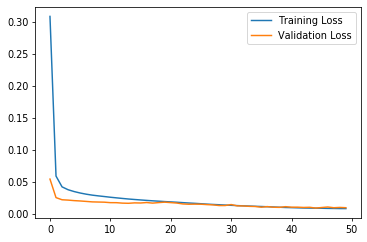

In [109]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Detecting anomalies
# We will detect anomalies by determining how well our model can reconstruct the input data.

# Find MAE loss on training samples.
# Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. 
# We will make this the threshold for anomaly detection.
# If the reconstruction loss for a sample is greater than this threshold value then we can infer that 
# the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

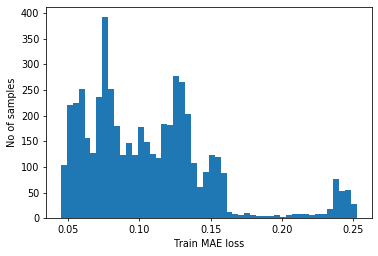

Reconstruction error threshold:  0.25236984824586006


In [139]:
# Get train MAE loss.
x_train_pred_AE = model_AE.predict(x_train_AE)
#value_train = x_train_AE[:,:,0]
#value_train_pred = x_train_pred_AE[:,:,0]
#train_mae_loss = np.mean(np.abs(value_train_pred - value_train), axis=1)
train_mae_loss = np.mean(np.abs(x_train_pred_AE - x_train_AE), axis=1)

plt.hist(train_mae_loss, bins=50, stacked=True)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

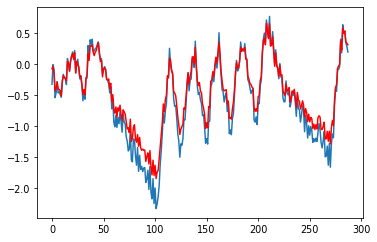

In [141]:
# Compare recontruction
# plot raw and reconstructed data

# Checking how the first sequence is learnt
# plt.plot(x_train_AE[0,:,0])
# plt.plot(x_train_pred_AE[0,:,0], c='r')
plt.plot(x_train_AE[0])
plt.plot(x_train_pred_AE[0], c='r')

plt.show()

In [142]:
# Create sequences from test values.
x_test_AE = create_sequences(x_test)
print("Test input shape: ", x_test_AE.shape)

Test input shape:  (1529, 288, 1)


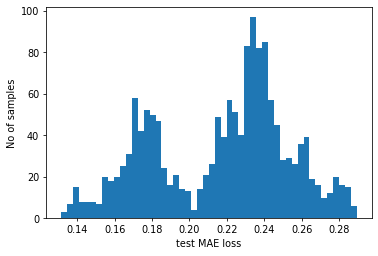

In [143]:
# Get test MAE loss.
x_test_pred_AE = model_AE.predict(x_test_AE)
# value_test = x_test_AE[:,:,0]
# value_test_pred = x_test_pred_AE[:,:,0]
# test_mae_loss = np.mean(np.abs(value_test_pred - value_test), axis=1)
# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred_AE - x_test_AE), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50, stacked=True)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [144]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  235
Indices of anomaly samples:  (array([ 534,  538,  542,  543,  546,  558,  618,  619,  621,  622,  623,
        624,  625,  626,  627,  628,  629,  630,  631,  632,  633,  634,
        635,  636,  637,  638,  639,  640,  641,  642,  643,  644,  645,
        646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,
        657,  658,  659,  660,  661,  662,  663,  664,  665,  666,  667,
        668,  669,  670,  671,  672,  673,  674,  675,  676,  677,  678,
        679,  680,  681,  682,  683,  684,  685,  686,  687,  688,  689,
        690,  691,  692,  693,  694,  695,  696,  697,  698,  699,  700,
        701,  702,  703,  704,  705,  706,  707,  708,  709,  710,  711,
        712,  713,  714,  715,  716,  717,  718,  719,  720,  721,  722,
        723,  725,  726,  727,  994,  996,  998, 1000, 1002, 1004, 1006,
       1008, 1010, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1

In [145]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(x_test_AE) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [146]:
len(anomalous_data_indices) #235<288

0